In [ ]:
import numpy as np
import pandas as pd
import csv
import pickle
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import seaborn as sns
from keras.utils import np_utils
from keras.layers import LSTM, BatchNormalization, Reshape
from keras.callbacks import ModelCheckpoint
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# enable gpu
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
def split_tuple(labels):
  label, snr = map(list, zip(*(x.split('_') for x in labels)))
  label,snr=np.array(label),np.array(snr)
  return label,snr

In [ ]:
def create_model():
  number_of_channels = 4 
  model = Sequential()
  
  model.add(Conv2D(64, (1,3),padding='same',input_shape=(128, number_of_channels,1), activation='relu'))

  model.add(Conv2D(16, (2,3),padding='same',activation='relu'))

  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Reshape((-1, 16)))
  model.add(LSTM(64))

  model.add(BatchNormalization())

  model.add(Dense(10, activation ='softmax'))

  

  return model

In [ ]:
samples = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/integral.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/labels.npy')
gc.collect()

77

In [ ]:
# to encode the labels
lb = LabelEncoder()

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(samples, labels,test_size=0.3, random_state=1 ,stratify=labels)
del samples
del labels
# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1,stratify=y_train)

y_train,snr_train = split_tuple(y_train)
y_test,snr_test = split_tuple(y_test)
y_val,snr_val=split_tuple(y_val)

# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))

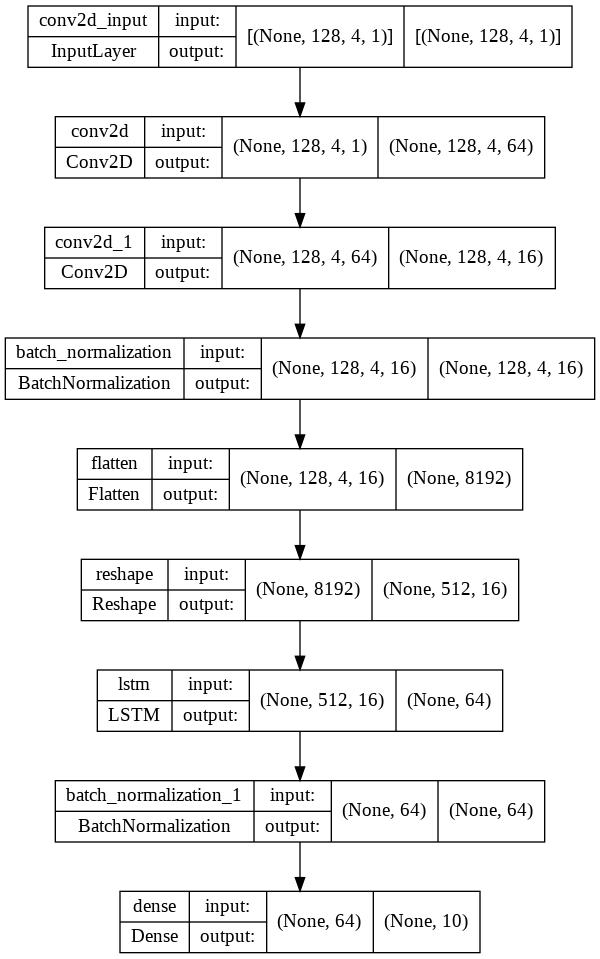

In [ ]:
# create model
model = create_model()
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam', metrics = ['accuracy'])

# Save an image of the model's architecture to a file
plot_model(model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

Epoch 1/15
24938/24938 [==============================] - ETA: 0s - loss: 0.9434 - accuracy: 0.6198
Epoch 1: loss improved from inf to 0.94338, saving model to /content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/bonus/nada_model.h5
24938/24938 [==============================] - 531s 21ms/step - loss: 0.9434 - accuracy: 0.6198 - val_loss: 0.9605 - val_accuracy: 0.6117
Epoch 2/15
24936/24938 [============================>.] - ETA: 0s - loss: 0.9404 - accuracy: 0.6206
Epoch 2: loss improved from 0.94338 to 0.94035, saving model to /content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/bonus/nada_model.h5
24938/24938 [==============================] - 502s 20ms/step - loss: 0.9404 - accuracy: 0.6206 - val_loss: 0.9526 - val_accuracy: 0.6173
Epoch 3/15
24937/24938 [============================>.] - ETA: 0s - loss: 0.9371 - accuracy: 0.6226
Epoch 3: loss improved from 0.94035 to 0.93709, saving model to /content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/bonus/nada_model.h5
24938

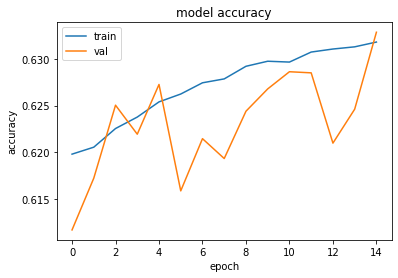

7734

In [ ]:
gc.collect()
model = load_model('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/bonus/nada_model.h5')
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/bonus/nada_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
#model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])# train model
cnn_results = model.fit(x_train, y_train_lb,
                  epochs = 15,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb),callbacks=callbacks_list)
# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
gc.collect()

In [ ]:
del x_train
del y_train
del y_val
del x_val
gc.collect()

341

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/bonus/nada_model.h5')


In [ ]:
# evaluate test set
# encode labels
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_test, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.633222222328186


In [ ]:
# to get confusion matrix

y_test_classes = y_test_lb.argmax(1)
y_predicted = model.predict(x_test)
y_pred_classes = np.argmax(y_predicted,axis=1)
classes = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/classes.npy')


In [ ]:
# get confusion matrix
confusion_matrix1 = confusion_matrix(y_true= y_test_classes, y_pred=y_pred_classes)
classes = np.array([x[0] for x in classes])
classes=np.unique(classes)
print(classes)
#Add labels to confusion matrix
confusion_matrix1 = pd.DataFrame(confusion_matrix1, columns=list(classes), index=list(classes))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix1

[b'8PSK' b'AM-DSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16' b'QAM64'
 b'QPSK' b'WBFM']
The rows represents the true values or observations
The columns respresent the model's predictions


,b'8PSK',b'AM-DSB',b'BPSK',b'CPFSK',b'GFSK',b'PAM4',b'QAM16',b'QAM64',b'QPSK',b'WBFM'
b'8PSK',25066,2356,320,2851,1688,508,1027,488,1470,226
b'AM-DSB',2935,28227,117,889,1255,188,76,6,81,2226
b'BPSK',5575,2353,21713,1840,1547,1801,458,110,352,251
b'CPFSK',5146,2345,225,24797,2026,373,399,106,344,239
b'GFSK',4099,2564,150,2116,25774,300,161,20,103,713
b'PAM4',3867,1753,1091,1411,1196,25812,381,128,187,174
b'QAM16',4510,1324,260,2207,1074,417,21647,3533,875,153
b'QAM64',3019,837,198,1760,693,342,3658,24568,830,95
b'QPSK',6592,2303,328,2924,1665,499,991,385,20102,211
b'WBFM',2983,19144,101,1026,2106,172,116,10,88,10254


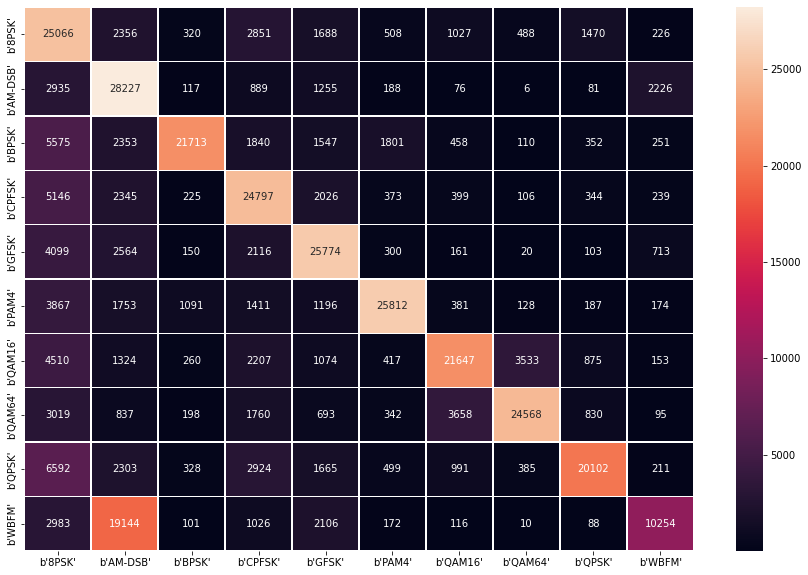

In [ ]:
# get most confusing classes
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix1, annot=True, linewidths=.5, ax=ax, fmt='g')

In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test_classes, y_pred_classes , average="macro"))
print("Recall: ",recall_score(y_test_classes, y_pred_classes , average="macro"))
print("F-score: ",f1_score(y_test_classes, y_pred_classes , average="macro"))

Percision:  0.6941325702691543
Recall:  0.6332222222222221
F-score:  0.6380697948576479


In [ ]:
# group by snr
snr_test = [int(snr) for snr in snr_test]
sorted_snrs = np.sort(np.unique(snr_test))
x = []
y = []
for snr in sorted_snrs:
  idx = np.where(snr_test == snr)
  x.append(snr)
  y.append(accuracy_score(np.argmax(y_test_lb[idx], axis = 1), np.argmax(y_predicted[idx], axis = 1)))


In [ ]:
# print results of snr
pd.DataFrame(data = np.array(y).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.97,11.37,12.77,15.49,21.54,31.81,39.37,51.17,68.03,82.06,89.04,91.4,92.08,92.71,92.53,92.83,92.69,92.81,92.86,92.92


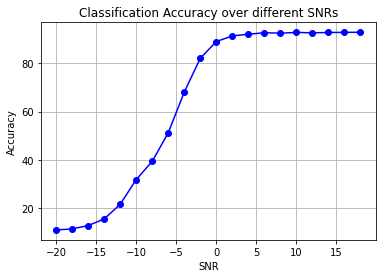

In [ ]:
# plot accuracy vs snr
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over different SNRs')
plt.plot(x, np.array(y) * 100, 'bo-')
plt.grid(True)